In [168]:
pip install matplotlib

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [169]:
pip install statsmodels

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [170]:
pip install tqdm

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from tqdm import tqdm
from multiprocessing.dummy import Pool
import statsmodels.formula.api as smf
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [172]:
crsp_df = pd.read_csv("crsp.zip", compression='zip',header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={"PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SPREAD": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str})
#Data Preprocessing
crsp_df = crsp_df[(crsp_df.SHRCD.isin(('10','11')))]
crsp_df = crsp_df[(crsp_df.date >= '1927-01-01')]
crsp_df = crsp_df[(crsp_df.date <= '2011-12-31')]
cusips_DISTCD_12 = crsp_df[crsp_df.DISTCD.apply(lambda x: x[:2]=='12' if isinstance(x, str) else False)].CUSIP.unique()
crsp_df = crsp_df[crsp_df.CUSIP.isin(cusips_DISTCD_12)]

crsp_df.PRC = crsp_df.PRC.abs()




crsp_df['year'] = crsp_df['date'].dt.year
crsp_df['month'] = crsp_df['date'].dt.month
crsp_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_df['PRC_t-1'] = crsp_df.groupby('CUSIP')['PRC'].shift(1)
crsp_df.head()


,PERMNO,date,SHRCD,TICKER,COMNAM,CUSIP,DCLRDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,RET,SHROUT,SPREAD,RETX,year,month,PRC_t-1
1359100,25881,1970-11-30,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,318.0,C,2655.0,NaN,C,1970,11,NaN
1359101,25881,1970-12-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,10.000,646.0,0.111111,2655.0,NaN,0.111111,1970,12,9.000
1359102,25881,1971-01-29,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,636.0,-0.100000,2655.0,NaN,-0.100000,1971,1,10.000
1359103,25881,1971-02-26,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,11.125,2155.0,0.236111,2655.0,NaN,0.236111,1971,2,9.000
1359104,25881,1971-03-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.750,2062.0,-0.123596,2655.0,NaN,-0.123596,1971,3,11.125


In [173]:
crsp_div_df = crsp_df[['date','CUSIP','DCLRDT','RCRDDT','DISTCD','DIVAMT','PRC','PRC_t-1','RET','SHROUT','month']].copy()
crsp_div_df 
crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df = crsp_div_df.groupby(by=['CUSIP','date']).agg({
     'DCLRDT': 'last',
     'RCRDDT': 'last',
     'DISTCD': 'last',
     'DIVAMT': 'sum',
     'RET':'max',
     'PRC': 'last',
     'PRC_t-1': 'last',
     'SHROUT': 'last'})
crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df['freq'] = None
crsp_div_df['freq'] = crsp_div_df[crsp_div_df.RCRDDT.isna()==False]['DISTCD'].apply(lambda x: x[2:3] if x is not None else None)
crsp_div_df['freq'] = crsp_div_df.groupby(by=['CUSIP']).fillna(method='ffill', limit=11)['freq']

fil_C = (crsp_div_df["PRC_t-1"] >= 5) & (crsp_div_df.freq < '6')
crsp_div_df = crsp_div_df[fil_C]

crsp_div_df['MCAP'] = crsp_div_df['PRC'] * crsp_div_df['SHROUT']
crsp_div_df

DCLRDT     RCRDDT DISTCD  DIVAMT        RET     PRC  \
CUSIP    date                                                                 
00003210 1977-06-30 1977-05-25 1977-06-24   1232    0.05   0.069388   6.500   
         1977-07-29        NaT        NaT   None    0.00   0.230769   8.000   
         1977-08-31        NaT        NaT   None    0.00   0.046875   8.375   
         1977-09-30 1977-08-02 1977-09-23   1232    0.05   0.080597   9.000   
         1977-10-31        NaT        NaT   None    0.00  -0.041667   8.625   
...                        ...        ...    ...     ...        ...     ...   
N5946510 2008-01-31        NaT        NaT   None    0.00   0.055477  14.840   
         2008-02-29        NaT        NaT   None    0.00  -0.202156  11.840   
         2008-03-31        NaT        NaT   None    0.00  -0.020270  11.600   
         2008-04-30        NaT        NaT   None    0.00   0.135345  13.170   
         2008-05-30        NaT        NaT   None    0.00   0.013667  13.350   

                     PRC_t-1    SHROUT freq         MCAP  
CUSIP    date                                             
00003210 1977-06-30    6.125    2209.0    3    14358.500  
         1977-07-29    6.500    2209.0    3    17672.000  
         1977-08-31    8.000    2209.0    3    18500.375  
         1977-09-30    8.375    2223.0    3    20007.000  
         1977-10-31    9.000    2223.0    3    19173.375  
...                      ...       ...  ...          ...  
N5946510 2008-01-31   14.060  304332.0    3  4516286.880  
         2008-02-29   14.840  304332.0    3  3603290.880  
         2008-03-31   11.840  304439.0    3  3531492.400  
         2008-04-30   11.600  304439.0    3  4009461.630  
         2008-05-30   13.170  304449.0    3  4064394.150  

[1494129 rows x 10 columns]

In [174]:
# a = pd.Series(['1.0',2.0,100.0,'C','B'])
# a < '65'
'B' < '65'

False

In [175]:
crsp_div_df['div_yr']=np.where(crsp_div_df['freq']=='6',True,False )
crsp_div_df['div_semi_annual']=np.where(crsp_div_df['freq']=='4',True,False)
crsp_div_df['div_quarterly']=np.where(crsp_div_df['freq']=='3',True,False)
crsp_div_df['div_unknown']=np.where(crsp_div_df['freq']=='0',True,False )
crsp_div_df['div_monthly']=np.where(crsp_div_df['freq']=='2',True,False )
crsp_temp=crsp_div_df


In [176]:
crsp_temp['lag_u_1']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(1)
crsp_temp['lag_u_2']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(2)
crsp_temp['lag_u_3']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(3)
crsp_temp['lag_u_4']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(4)
crsp_temp['lag_u_5']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(5)
crsp_temp['lag_u_6']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(6)
crsp_temp['lag_u_7']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(7)
crsp_temp['lag_u_8']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(8)
crsp_temp['lag_u_9']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(9)
crsp_temp['lag_u_10']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(10)
crsp_temp['lag_u_11']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(11)
crsp_temp['lag_u_12']=crsp_temp.groupby('CUSIP')['div_unknown'].shift(12)

crsp_temp['lag_quarterly']=crsp_temp.groupby('CUSIP')['div_quarterly'].shift(3)
crsp_temp['lag_semi_annual_six']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(6)
crsp_temp['lag_semi_annual_twl']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(12)
crsp_temp['lag_div_yr']=crsp_temp.groupby('CUSIP')['div_yr'].shift(12)
crsp_temp['lag_1']=crsp_temp.groupby('CUSIP')['div_monthly'].shift(1)
crsp_temp['lag_4']=crsp_temp.groupby('CUSIP')['div_monthly'].shift(4)
crsp_temp['lag_7']=crsp_temp.groupby('CUSIP')['div_monthly'].shift(7)
crsp_temp['lag_10']=crsp_temp.groupby('CUSIP')['div_monthly'].shift(10)

crsp_div_df['lag_month']=crsp_temp.groupby('CUSIP')['div_monthly'].shift(1)

crsp_temp

DCLRDT     RCRDDT DISTCD  DIVAMT        RET     PRC  \
CUSIP    date                                                                 
00003210 1977-06-30 1977-05-25 1977-06-24   1232    0.05   0.069388   6.500   
         1977-07-29        NaT        NaT   None    0.00   0.230769   8.000   
         1977-08-31        NaT        NaT   None    0.00   0.046875   8.375   
         1977-09-30 1977-08-02 1977-09-23   1232    0.05   0.080597   9.000   
         1977-10-31        NaT        NaT   None    0.00  -0.041667   8.625   
...                        ...        ...    ...     ...        ...     ...   
N5946510 2008-01-31        NaT        NaT   None    0.00   0.055477  14.840   
         2008-02-29        NaT        NaT   None    0.00  -0.202156  11.840   
         2008-03-31        NaT        NaT   None    0.00  -0.020270  11.600   
         2008-04-30        NaT        NaT   None    0.00   0.135345  13.170   
         2008-05-30        NaT        NaT   None    0.00   0.013667  13.350   

                     PRC_t-1    SHROUT freq         MCAP  ...  lag_u_12  \
CUSIP    date                                             ...             
00003210 1977-06-30    6.125    2209.0    3    14358.500  ...       NaN   
         1977-07-29    6.500    2209.0    3    17672.000  ...       NaN   
         1977-08-31    8.000    2209.0    3    18500.375  ...       NaN   
         1977-09-30    8.375    2223.0    3    20007.000  ...       NaN   
         1977-10-31    9.000    2223.0    3    19173.375  ...       NaN   
...                      ...       ...  ...          ...  ...       ...   
N5946510 2008-01-31   14.060  304332.0    3  4516286.880  ...     False   
         2008-02-29   14.840  304332.0    3  3603290.880  ...     False   
         2008-03-31   11.840  304439.0    3  3531492.400  ...     False   
         2008-04-30   11.600  304439.0    3  4009461.630  ...     False   
         2008-05-30   13.170  304449.0    3  4064394.150  ...     False   

                     lag_quarterly  lag_semi_annual_six  lag_semi_annual_twl  \
CUSIP    date                                                                  
00003210 1977-06-30            NaN                  NaN                  NaN   
         1977-07-29            NaN                  NaN                  NaN   
         1977-08-31            NaN                  NaN                  NaN   
         1977-09-30           True                  NaN                  NaN   
         1977-10-31           True                  NaN                  NaN   
...                            ...                  ...                  ...   
N5946510 2008-01-31           True                False                False   
         2008-02-29           True                False                False   
         2008-03-31           True                False                False   
         2008-04-30           True                False                False   
         2008-05-30           True                False                False   

                     lag_div_yr  lag_1  lag_4  lag_7 lag_10 lag_month  
CUSIP    date                                                          
00003210 1977-06-30         NaN    NaN    NaN    NaN    NaN       NaN  
         1977-07-29         NaN  False    NaN    NaN    NaN     False  
         1977-08-31         NaN  False    NaN    NaN    NaN     False  
         1977-09-30         NaN  False    NaN    NaN    NaN     False  
         1977-10-31         NaN  False  False    NaN    NaN     False  
...                         ...    ...    ...    ...    ...       ...  
N5946510 2008-01-31       False  False  False  False  False     False  
         2008-02-29       False  False  False  False  False     False  
         2008-03-31       False  False  False  False  False     False  
         2008-04-30       False  False  False  False  False     False  
         2008-05-30       False  False  False  False  False     False  

[1494129 rows x 36 columns]

In [177]:
# Strategies 1: Long predicted dividend and short all other companies
crsp_temp['long_stocks'] = (crsp_temp['lag_u_3'] ==True) | (crsp_temp['lag_u_6'] ==True) | ( crsp_temp['lag_u_9'] ==True ) | (crsp_temp['lag_u_12'] ==True ) | ( crsp_temp['lag_quarterly'] ==True ) | (crsp_temp['lag_semi_annual_six'] ==True ) | (crsp_temp['lag_semi_annual_twl'] ==True) |(crsp_temp['lag_div_yr'] ==True)

crsp_temp['short_stocks'] = np.where(crsp_temp['long_stocks']==False,True,False)

# Strategies 2: Long predicted dividend and short all other dividend payers companies
# crsp_temp['short_stocks'] = (crsp_temp['lag_u_1'] ==True) | (crsp_temp['lag_u_2'] ==True) | ( crsp_temp['lag_u_4'] ==True ) | (crsp_temp['lag_u_5'] ==True ) | ( crsp_temp['lag_u_8'] ==True ) | (crsp_temp['lag_u_10'] ==True ) | (crsp_temp['lag_u_11'] ==True )| (crsp_div_df['lag_month']==True)

# Strategies 3: Long predicted dividend and short all months occurring 1,4,7 or 10 months ago
# crsp_temp['short_stocks'] = (crsp_temp['lag_1'] ==True) | (crsp_temp['lag_4'] ==True) | ( crsp_temp['lag_7'] ==True ) | (crsp_temp['lag_10'] ==True ) 
# crsp_temp['short_stocks'].describe()



In [178]:
def long_weights(group):
    # Select all stocks with long position from the group
    longs = group.loc[group['long_stocks'] == True]
    # Get market capitalization of each long stock
    mktcap = longs['SHROUT'] * longs['PRC']
    # Calculate long weights by market captalization
    longweights = mktcap / mktcap.sum()
    # Assign weights for the group of long stocks
    group.loc[group['long_stocks']==True, 'long_weight'] = longweights
    group['long_weight'] = group['long_weight'].shift(1)
    return group

def short_weights(group):
    # Select all stocks with short position from the group
    shorts = group.loc[group['short_stocks'] == True]
    # Get market capitalization of each short stock
    mktcap = shorts['SHROUT'] * shorts['PRC']
    # Calculate short weights by market captalization
    shortweights = mktcap / mktcap.sum()
    # Assign weights for the group of short stocks
    group.loc[group['short_stocks']==True, 'short_weight'] = shortweights
    return group

def cal_return_vw(group):
    # group=group[(group.RET<='65')]
    group =  group[( group['RET'].apply(lambda x: str(x)[-1].isdigit()) )]
    group['port_return_long_vw'] = pd.to_numeric(group['RET']) * pd.to_numeric(group['long_weight'])
 
    longport = pd.pivot_table(group, values='port_return_long_vw', index='date', aggfunc='mean')
    print(group['port_return_long_vw'])
    print(longport)
    group['port_return_short_vw'] = pd.to_numeric(group['RET']) * pd.to_numeric(group['short_weight'])
    shortport = pd.pivot_table(group, values='port_return_short_vw', index='date', aggfunc='mean')

    data=pd.merge(longport, shortport, on='date')
    
    data['longshort_vw'] = data['port_return_long_vw'] - data['port_return_short_vw']
    print(data)
    return longport,shortport,data

def cal_return_eq(group):
    #Kobe Updated part, 
    longs = group.loc[group['long_stocks'] == True]
    longs =  longs[( longs['RET'].apply(lambda x: str(x)[-1].isdigit()) )] # this function for filter out number
    longs['RET'] = longs['RET'].astype('float64')
    longport = longs.RET.groupby('date').mean() 


    shorts = group.loc[group['short_stocks'] == True]
    shorts =  shorts[( shorts['RET'].apply(lambda x: str(x)[-1].isdigit()) )]
    shorts['RET'] = shorts['RET'].astype('float64')
    shortport = shorts.RET.groupby('date').mean()
    
    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_eq'] = data.RET_long  - data.RET_short
    # print(data)
    # print(shortport)
    # print(longshortport)
    
    return longport,shortport,data

panel=long_weights(crsp_temp)
panel=short_weights(panel)
longport_vw,shortport_vw,longshortport_vw=cal_return_vw(panel)
longport_eq,shortport_eq,longshortport_eq=cal_return_eq(crsp_temp)



<ipython-input-178-139d496e3e5f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['port_return_long_vw'] = pd.to_numeric(group['RET']) * pd.to_numeric(group['long_weight'])
CUSIP     date      
00003210  1977-06-30             NaN
          1977-07-29             NaN
          1977-08-31             NaN
          1977-09-30             NaN
          1977-10-31   -3.670790e-10
                            ...     
N5946510  2008-01-31    1.038613e-07
          2008-02-29   -4.020254e-07
          2008-03-31   -3.216165e-08
          2008-04-30    2.104679e-07
          2008-05-30    2.412929e-08
Name: port_return_long_vw, Length: 1487194, dtype: float64
            port_return_long_vw
date                           
1927-01-31         4.0631

In [179]:
ff4=pd.read_csv('four_factor_monthly.csv',index_col='date')
liq_df=pd.read_csv('liq_monthly.csv',index_col='date')
# merging with liquidity dataset
# ff4['merge_date']=ff4['date'].apply(lambda x: str(x)[0:7].replace('-',''))
# ff4 = ff4.set_index('merge_date')
# ff4.index=ff4.index.astype(str).astype(int)

# liquid_df= pd.read_csv('liq_data.csv',index_col='date')
# liq_df = pd.merge(ff4, liquid_df, how='inner', left_index=True, right_index=True)

# liq_df.to_csv('liq_monthly.csv',index='False')
ff4.index = pd.to_datetime(ff4.index)
liq_df.index = pd.to_datetime(liq_df.index)
liq_df

,Unnamed: 0,mkt_rf,smb,hml,rf,Mom,liq,Unnamed: 2
date,,,,,,,,
1970-11-30,197011,0.046048,-0.038764,0.014840,0.004610,0.022107,-0.005801,NaN
1970-12-31,197012,0.057196,0.027770,0.008493,0.004188,-0.023865,0.051033,NaN
1971-01-31,197101,0.048245,0.070373,0.013047,0.003807,-0.065202,-0.052025,NaN
1971-02-28,197102,0.014028,0.018771,-0.012779,0.003235,0.011666,-0.020223,NaN
1971-03-31,197103,0.041488,0.024413,-0.037557,0.002994,-0.009063,0.017893,NaN
...,...,...,...,...,...,...,...,...
2020-06-30,202006,0.025170,0.028277,-0.017412,0.000000,-0.031745,0.062176,NaN
2020-07-31,202007,0.057269,-0.020489,-0.014042,0.000000,0.058925,-0.012027,NaN
2020-08-31,202008,0.076499,-0.002268,-0.028171,0.000000,-0.000850,0.034763,NaN


,mkt_rf,smb,hml,rf,Mom,RET
date,,,,,,
1927-04-30,0.005123,0.004924,0.004737,0.002503,0.041533,0.018177
1927-05-31,0.053512,0.013014,0.047367,0.003004,0.035404,0.051929
1927-06-30,-0.023892,0.003808,-0.015245,0.002503,0.020166,-0.020331
1927-08-31,0.020027,-0.007575,-0.035480,0.002704,0.026867,0.011821
1927-09-30,0.048230,-0.033924,-0.006663,0.002002,0.027053,0.035153
...,...,...,...,...,...,...
2011-06-30,-0.017457,-0.000473,-0.004444,0.000000,0.018392,-0.008909
2011-08-31,-0.059974,-0.028293,-0.024706,0.000000,-0.002962,-0.060211
2011-09-30,-0.075968,-0.034320,-0.015275,0.000000,0.023169,-0.085287


In [180]:
# equal_weighted_long
# data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date'))
    .fit().summary()
)

# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2463.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2064.2
No. Observations:                 744   AIC:                            -4118.
Df Residuals:                     739   BIC:                            -4095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.001      8.844      0.0

In [181]:
# value_weighted_long
data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('port_return_long_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_vw, on='date'))
    .fit().summary()
)

# value_weighted_short
print (
    smf.ols('port_return_short_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_vw, on='date'))
    .fit().summary()
)
# value_weighted_diff
print
(
    smf.ols('longshort_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_vw, on='date'))
    .fit().summary()
)

                             OLS Regression Results                            
Dep. Variable:     port_return_long_vw   R-squared:                       0.226
Model:                             OLS   Adj. R-squared:                  0.222
Method:                  Least Squares   F-statistic:                     54.22
Date:                 Sun, 30 May 2021   Prob (F-statistic):           4.12e-40
Time:                         20:13:12   Log-Likelihood:                 6155.6
No. Observations:                  747   AIC:                        -1.230e+04
Df Residuals:                      742   BIC:                        -1.228e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.488e-06   2.41e-06      2.28

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           longshort_vw   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     26.53
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.37e-20
Time:                        20:13:12   Log-Likelihood:                 5391.0
No. Observations:                 747   AIC:                        -1.077e+04
Df Residuals:                     742   BIC:                        -1.075e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.425e-05   6.69e-06     -2.129      0.034   -2.74e-05   -1.11e-06
hml            0.0012      0.000      6.192      0.000       0.001       0.002
mkt_rf        -0.0005      0.000     -3.826      0.000      -0.001      -0.000
smb           -0.0010      0.000     -4.627      0.000      -0.001      -0.001
Mom           -0.0007      0.000     -4.852      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1127.399   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           465618.991
Skew:                          -8.454   Prob(JB):                         0.00
Kurtosis:                     124.135   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
# panel B do one strategies 1 & 2 
# CAPM Alpha

print( smf.ols('RET ~ 1 + mkt_rf', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + mkt_rf ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + mkt_rf', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5982.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 1893.6
No. Observations:                 744   AIC:                            -3783.
Df Residuals:                     742   BIC:                            -3774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.001      7.261      0.0

In [183]:
# 3-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     3159.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2050.2
No. Observations:                 744   AIC:                            -4092.
Df Residuals:                     740   BIC:                            -4074.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0045      0.001      7.835      0.0

In [184]:
# 4-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2463.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:                 2064.2
No. Observations:                 744   AIC:                            -4118.
Df Residuals:                     739   BIC:                            -4095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.001      8.844      0.0

In [185]:
# liquidity Alpha for strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq', data=pd.merge(liq_df, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq ', data=pd.merge(liq_df, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom +liq', data=pd.merge(liq_df, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     691.8
Date:                Sun, 30 May 2021   Prob (F-statistic):          9.35e-176
Time:                        20:13:12   Log-Likelihood:                 992.59
No. Observations:                 346   AIC:                            -1973.
Df Residuals:                     340   BIC:                            -1950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0060      0.001      7.554      0.0

date
1927-04-30    0.018359
1927-05-31    0.020008
1927-06-30    0.002952
1927-07-30    0.005783
1927-08-31    0.019885
                ...   
2011-08-31   -0.872873
2011-09-30   -0.870373
2011-10-31   -0.871786
2011-11-30   -0.873349
2011-12-30   -0.872611
Name: cum_ew, Length: 1017, dtype: float64


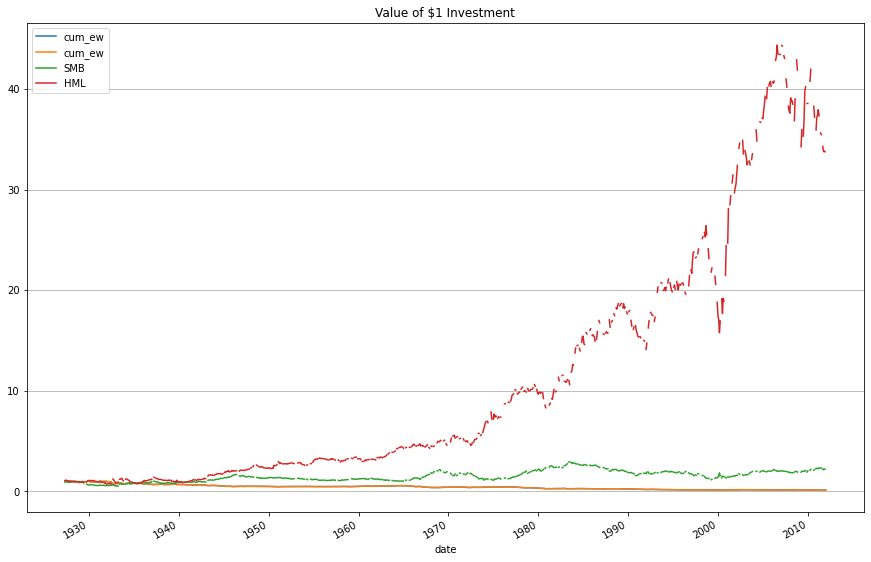

In [187]:
# Figure 1
portfolios = pd.DataFrame()
portfolios['cum_ew'] = (longshortport_eq['longshort_eq'] + 1).cumprod() - 1
print(portfolios['cum_ew'])
portfolios['cum_vw'] = (longshortport_vw['longshort_vw'] + 1).cumprod() - 1
portfolios['SMB']= (ff4['smb']+ 1).cumprod() - 1
portfolios['HML']= (ff4['hml']+ 1).cumprod() - 1
portfolios=portfolios.reset_index()
portfolios
# Within-companies Predicted Dividend Portfolio
(
    portfolios
    .assign(date=pd.to_datetime(portfolios['date']))
    .assign(cum_ew=portfolios['cum_ew']+1)
    .assign(cum_vw=portfolios['cum_vw']+1)
    .assign(SMB=portfolios['SMB']+1)
    .assign(HML=portfolios['HML']+1)
    .plot(x='date', y=['cum_ew', 'cum_ew','SMB','HML'],figsize=(15,10),title='Value of $1 Investment').grid(axis='y')
)